In [2]:
import pandas as pd
import nltk
import numpy as np
import string

import gensim
from sklearn.pipeline import Pipeline
from preprocessing import *
from numpy import array 
from numpy import dot
from numpy.linalg import norm

In [3]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

In [4]:
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet
import re

In [5]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(inplace = True)
print(dataset.shape)

(3150, 5)
(3150, 5)
(2998, 5)
(2322, 5)


In [6]:
w2v_model = Word2Vec.load("w2vPreTrained")

In [7]:
w2v_model.wv.most_similar(['love'], topn = 10)

[('enjoy', 0.5578348636627197),
 ('great', 0.5526167154312134),
 ('amaze', 0.5221312046051025),
 ('like', 0.4955675005912781),
 ('awesome', 0.43842583894729614),
 ('favorite', 0.42576074600219727),
 ('fun', 0.4234786629676819),
 ('amazing', 0.4115583598613739),
 ('fantastic', 0.408966600894928),
 ('nice', 0.3966287672519684)]

In [8]:
w2v_model.wv.most_similar(['love'], topn = len(w2v_model.wv.vectors))[-10:] # less similar words

[('may', -0.3007705509662628),
 ('not_internet', -0.3016756474971771),
 ('not_drop', -0.30507779121398926),
 ('hype', -0.3121069371700287),
 ('tight', -0.31214627623558044),
 ('not_voice', -0.3136102557182312),
 ('crash', -0.3138749599456787),
 ('not_ready', -0.3269640803337097),
 ('not_sync', -0.33947843313217163),
 ('processor', -0.37799587845802307)]

In [9]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [10]:
words_wv = w2v_model.wv.index_to_key
len(words_wv)

3454

In [11]:
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(w2v_model.wv.vectors)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(w2v_model.wv.vectors,kmeans.labels_))

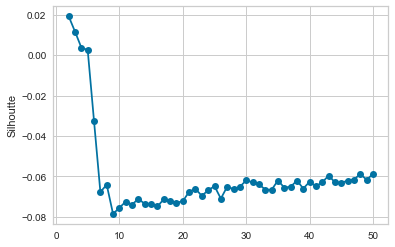

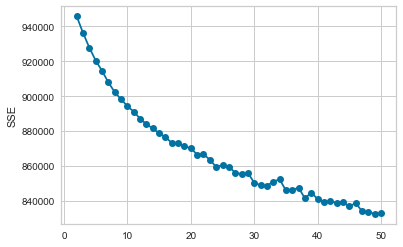

In [15]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeans.fit(w2v_model.wv.vectors)

KMeans(n_clusters=2)

In [17]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1]), array([1997, 1457], dtype=int64))

In [18]:
len(centers)

2

In [19]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=40))
    print("####################################################")

[('comprar', 0.42091014981269836), ('confident', 0.3671967685222626), ('problemas', 0.3587481379508972), ('lack', 0.3548409342765808), ('duty', 0.3538508713245392), ('mediocre', 0.3534342348575592), ('único', 0.34898146986961365), ('gran', 0.34752535820007324), ('punchy', 0.3465113043785095), ('conectar', 0.34518739581108093), ('otro', 0.34511592984199524), ('boomy', 0.34271904826164246), ('processing', 0.3408876657485962), ('material', 0.33686283230781555), ('funciones', 0.331393301486969), ('celular', 0.3308953046798706), ('design', 0.33008629083633423), ('phillips', 0.3296210765838623), ('overprice', 0.3262077569961548), ('otros', 0.3257822096347809), ('cualquier', 0.3255789577960968), ('carro', 0.3233692944049835), ('puedes', 0.3224022388458252), ('audiophiles', 0.3201165497303009), ('comandos', 0.3197002708911896), ('perfectamente', 0.3184366226196289), ('requirement', 0.3170367181301117), ('massive', 0.3169139325618744), ('satisfecho', 0.3164788782596588), ('build', 0.31582990288

In [20]:
df = pd.DataFrame()

In [21]:
print(len(w2v_model.wv["love"]))
print(len(centers[0])) # to check if the vectors have the same length

100
100


In [46]:
words = []
labels = []
cos = []
for w, label in zip(words_wv, kmeans.labels_):
    # this calculates the similarity bewtween centroids and all the words in their clusters
    try:
        cos_sim = dot(w2v_model.wv[w], centers[label])/(norm(w2v_model.wv[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    except:
        continue
    words.append(w)
    labels.append(label)
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown()) # shows the most similar words to that cluster

|      | word              |   labels |          cos |
|-----:|:------------------|---------:|-------------:|
|   96 | sometimes         |        1 |  0.493088    |
|  150 | stop              |        1 |  0.482964    |
|   65 | tell              |        1 |  0.463378    |
|  669 | randomly          |        1 |  0.437078    |
|   86 | start             |        1 |  0.433757    |
|   13 | time              |        1 |  0.421023    |
|  296 | happen            |        1 |  0.402489    |
|  437 | usually           |        1 |  0.398986    |
| 2440 | proceed           |        1 |  0.391267    |
|  313 | annoy             |        1 |  0.380076    |
|   26 | say               |        1 |  0.373578    |
| 2964 | vice_versa        |        1 |  0.369098    |
|  922 | prompt            |        1 |  0.368686    |
|  129 | talk              |        1 |  0.36806     |
|  974 | reboot            |        1 |  0.366833    |
|  688 | correct           |        1 |  0.36277     |
|  408 | w

In [47]:
from sklearn.manifold import TSNE

In [48]:
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [49]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [50]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [52]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

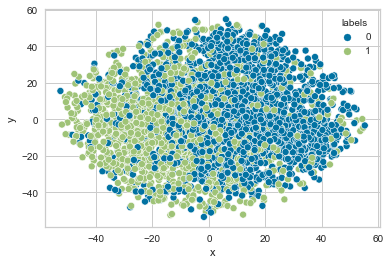

In [53]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [54]:
import plotly_express as px

In [55]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", color = [str(x) for x in df["labels"]], hover_name = "word")

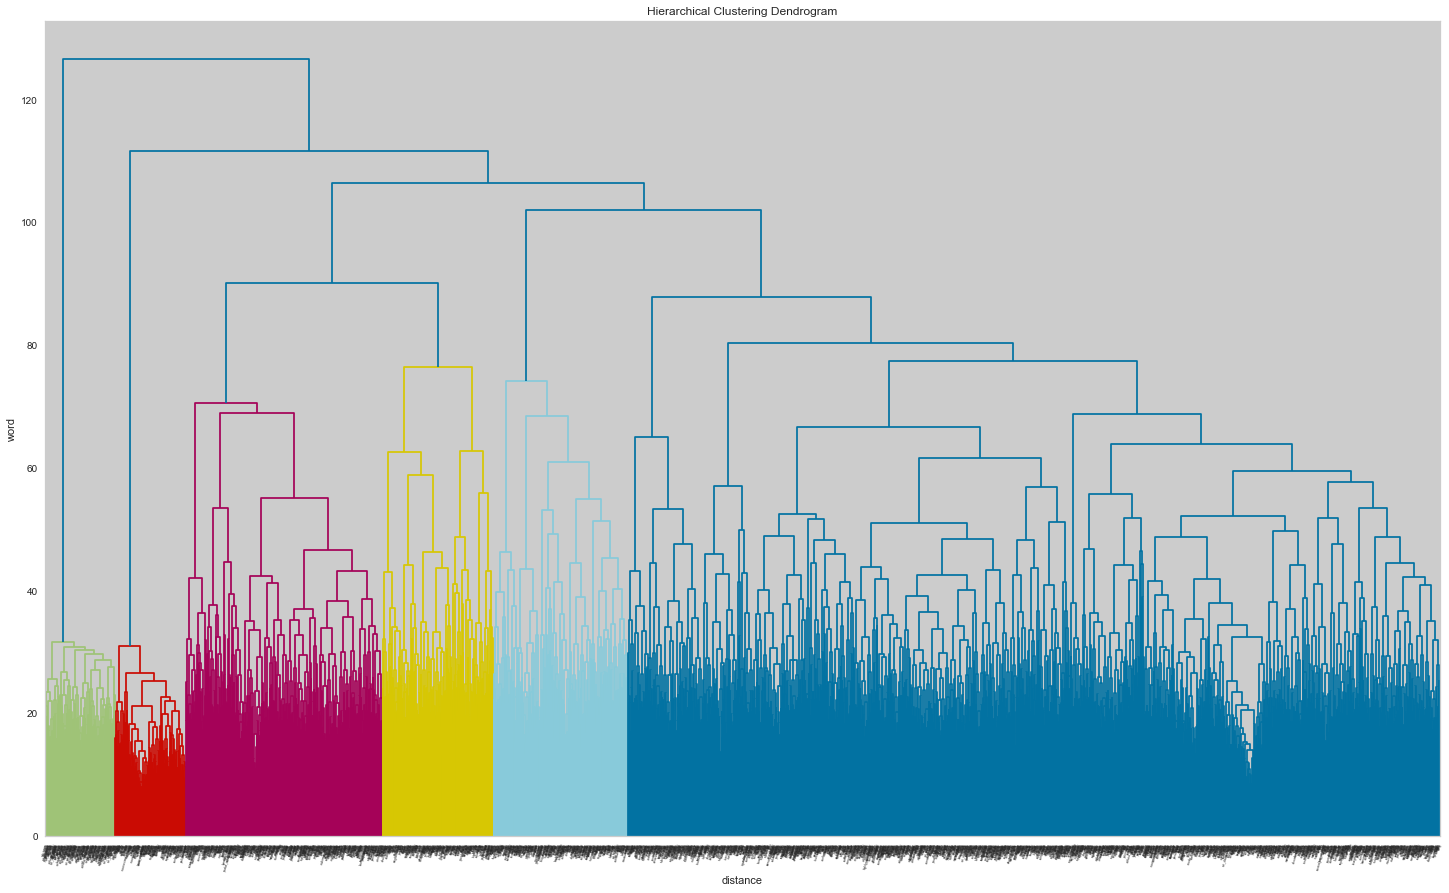

In [56]:
# distance_matrix = pairwise_distances(vectors, vectors, metric = "cosine")
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

l = linkage(w2v_model.wv.vectors, method='ward', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=75.,  # rotates the x axis labels
    leaf_font_size=3.,  # font size for the x axis labels
    leaf_label_func=lambda v: str(w2v_model.wv.index_to_key[v])
)
plt.show()

In [60]:
hier_df = pd.DataFrame()

hier_labels = fcluster(l, 6, "maxclust")
hier_df["labels"] = hier_labels

hier_df["x"] = df["x"]
hier_df["y"] = df["y"]
hier_df["z"] = df["z"]
hier_df["word"] = df["word"]
print(hier_df[hier_df["labels"] == 1].to_markdown())

|      |   labels |           x |        y |           z | word              |
|-----:|---------:|------------:|---------:|------------:|:------------------|
|  344 |        1 |   0.132655  | 34.45    |  10.0071    | not_sure          |
|  490 |        1 |  21.1585    | 40.3036  |  17.3575    | not_work          |
|  551 |        1 |   8.83998   | 32.1661  |  27.3467    | not_use           |
|  624 |        1 |   8.66726   | 40.8448  |   6.67605   | not_good          |
|  787 |        1 |   8.50459   | 49.535   |  15.2885    | not_able          |
|  791 |        1 |   9.90817   | 32.3016  |  16.4247    | not_get           |
|  814 |        1 |   5.65721   | 38.4385  |  13.9226    | not_connect       |
|  817 |        1 |  17.4858    | 33.2469  |   7.8517    | not_much          |
|  832 |        1 |   6.86141   | 30.4487  |  27.9443    | not_like          |
|  850 |        1 |   3.13337   | 34.8973  |  30.6883    | not_great         |
|  912 |        1 |  15.8817    | 37.2364  |  28.028

In [61]:
px.scatter_3d(data_frame = hier_df, x = "x", y = "y", z = "z", color = [str(x) for x in hier_df["labels"]], hover_name = "word")

In [12]:
# THIS CALCULATES DISTANCES BEWTWEEN EACH WORD AND THE POSITIVE-NEGATIVE CENTROID

df_polarity = pd.DataFrame()

words = []
positive_centroid = "love"
negative_centroid = "issue"
positive = []
negative = []

for w in words_wv:
    words.append(w)
    pos = dot(w2v_model.wv[w], w2v_model.wv[positive_centroid])/(norm(w2v_model.wv[w])*norm(w2v_model.wv[positive_centroid]))
    neg = dot(w2v_model.wv[w], w2v_model.wv[negative_centroid])/(norm(w2v_model.wv[w])*norm(w2v_model.wv[negative_centroid]))
    # neg = 1-pos
    positive.append(pos)
    negative.append(neg)

df_polarity["word"] = words
df_polarity["pos_score"] = positive
df_polarity["neg_score"] = negative

df_polarity.sort_values(by = "neg_score", ascending = False).head(15)

,word,pos_score,neg_score
52,issue,-0.113491,1.000000
75,problem,-0.052833,0.809527
897,glitch,-0.114678,0.556553
316,complaint,-0.023352,0.517431
677,bug,-0.087293,0.459116
272,lose,-0.131038,0.422852
1552,hiccup,-0.039136,0.395072
1565,spotty,-0.124961,0.382001
1086,flaw,-0.052334,0.379053
2153,downfall,-0.068419,0.349714


In [13]:
def scoring_function(x, pos_w, neg_w, w2v):
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    i = 0
    for review in bigrams_clean[x]:
        score = 0
        for w in review:
            try:
                vec = w2v[w]
                pos = dot(vec, w2v[pos_w])/(norm(vec)*norm(w2v[pos_w]))
                neg = dot(vec, w2v[neg_w])/(norm(vec)*norm(w2v[neg_w]))
                score += pos
                score -= neg
            except KeyError:
                continue
        if score > 0:
            predicted.append(1)
        elif score < 0:
            predicted.append(0)
        else:
            predicted.append(0)
        i+=1

    return predicted

In [14]:
def scoring_functionV3(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            pos_sim_list = []
            neg_sim_list = []
            try:
                vec = w2v[w]
            except KeyError:
                continue
            for w_pos, w_neg in zip(pos_list, neg_list):
                pos_sim = dot(vec, w2v[w_pos])/(norm(vec)*norm(w2v[w_pos]))
                neg_sim = dot(vec, w2v[w_neg])/(norm(vec)*norm(w2v[w_neg]))  
                pos_sim_list.append(pos_sim) 
                neg_sim_list.append(neg_sim)
            pos = statistics.mean(pos_sim_list)
            neg = statistics.mean(neg_sim_list)
            if stampa:
                print(w, "pos:", pos, "neg:", neg)
            pos_score += statistics.mean(pos_sim_list)
            neg_score += statistics.mean(neg_sim_list)

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [15]:
def scoring_functionV3(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x, scoring="npmi", threshold=0.60)
    pos_average_vector = np.zeros(w2v.vector_size).reshape((w2v.vector_size, ))
    neg_average_vector = np.zeros(w2v.vector_size).reshape((w2v.vector_size, ))
    for word in pos_list:
        try:
            pos_average_vector += w2v[word]
        except KeyError:
            continue
    for word in neg_list:
        try:
            neg_average_vector += w2v[word]
        except KeyError:
            continue

    pos_average_vector = pos_average_vector / norm(pos_average_vector)
    neg_average_vector = neg_average_vector / norm(neg_average_vector)


    # print(clean)
    predicted = []
    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            try:
                vec = w2v[w]
            except KeyError:
                continue
            pos_sim = dot(vec, pos_average_vector)/(norm(vec)*norm(pos_average_vector))
            neg_sim = dot(vec, neg_average_vector)/(norm(vec)*norm(neg_average_vector))  
            if stampa:
                print(w, "pos:", pos_sim, "neg:", neg_sim)
            pos_score += pos_sim
            neg_score += neg_sim

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [16]:
y = []
x = []

for feedback, review in zip(dataset["feedback"], dataset["verified_reviews"]):
    y.append(feedback)
    x.append(review)
    
x_test = tokenize_list_of_text(x, custom_stopwords, False, pos_list)[1]

total number of types extracted is: 3108


In [17]:
target_neg = ['trouble', 'reset', 'fix', 'terrible', 'stupid', 'issue', 'bad', 'complain', "disappoint", "glitch", "bug"]
target_pos = ['love', 'enjoy', 'amazing', 'great', 'awesome', 'fun', 'nice', "wonderful"]
                       
predicted = scoring_function(x_test, "great", "bad", w2v_model.wv)
print(classification_report(y, predicted))
predicted = scoring_functionV3(x_test, target_pos, target_neg, w2v_model.wv, stampa = False)
print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.30      0.70      0.42       221
           1       0.96      0.83      0.89      2101

    accuracy                           0.82      2322
   macro avg       0.63      0.77      0.66      2322
weighted avg       0.90      0.82      0.85      2322

              precision    recall  f1-score   support

           0       0.32      0.81      0.46       221
           1       0.98      0.82      0.89      2101

    accuracy                           0.82      2322
   macro avg       0.65      0.82      0.68      2322
weighted avg       0.91      0.82      0.85      2322



In [19]:
for pred, review, correct in zip(predicted, x_test, y):
    print("prediction:", pred, "true label:", correct)
    print(review)
    print("################")

prediction: 1 true label: 1
['love']
################
prediction: 1 true label: 1
['love']
################
prediction: 0 true label: 1
['sometimes', 'play', 'game', 'answer', 'question', 'correctly', 'say', 'get', 'wrong', 'answer', 'like', 'able', 'turn', 'light', 'away', 'home']
################
prediction: 1 true label: 1
['lot', 'fun', 'thing', 'old', 'learn', 'dinosaur', 'control', 'light', 'play', 'game', 'like', 'category', 'nice', 'sound', 'play', 'music', 'well']
################
prediction: 1 true label: 1
['music']
################
prediction: 1 true label: 1
['receive', 'gift', 'need', 'another', 'bluetooth', 'something', 'play', 'music', 'easily', 'accessible', 'find', 'smart', 'speaker', 'wait', 'see', 'else']
################
prediction: 0 true label: 1
['think', 'one', "'ve", 'purchase', 'work', 'get', 'one', 'every', 'room', 'house', 'really', 'like', 'feature', 'offer', 'specifily', 'play', 'music', 'control', 'light', 'throughout', 'house']
################
predicti

In [37]:
stringa = """Disappointed, the product is lame and the sound is awful"""

In [38]:
x = tokenize_list_of_text([stringa], custom_stopwords, False, pos_list)[1]
scoring_functionV3(x, target_pos, target_neg, w2v_model.wv)

total number of types extracted is: 5
disappoint pos: 0.003657292946417122 neg: 0.3073998809167362
product pos: -0.2390507480792127 neg: 0.11382870949182644
lame pos: -0.09351856819822625 neg: 0.06604430977381236
sound pos: -0.048542668931525534 neg: -0.11123124124924119
awful pos: 0.09712546991129371 neg: 0.2508876873266784


[0]

In [128]:
w2v_model.wv.relative_cosine_similarity("love", "disappoint")

-0.007805441963332647